# 中文论文数据处理代码

## 优化目标的收敛性比较图

<Figure size 400x350 with 0 Axes>

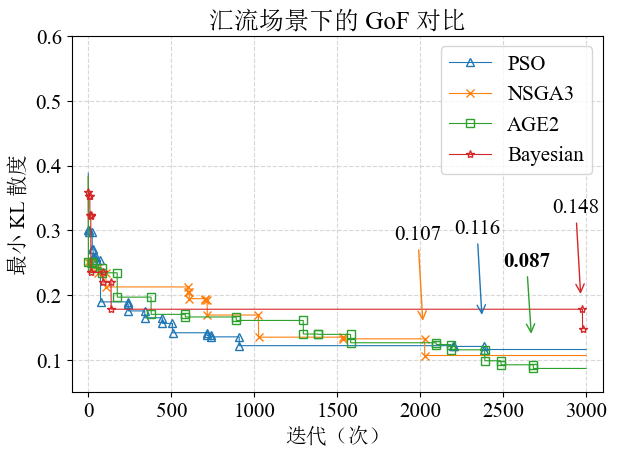

<Figure size 400x350 with 0 Axes>

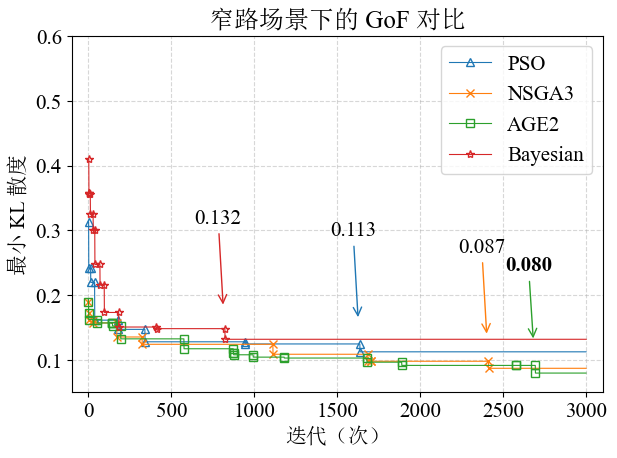

<Figure size 400x350 with 0 Axes>

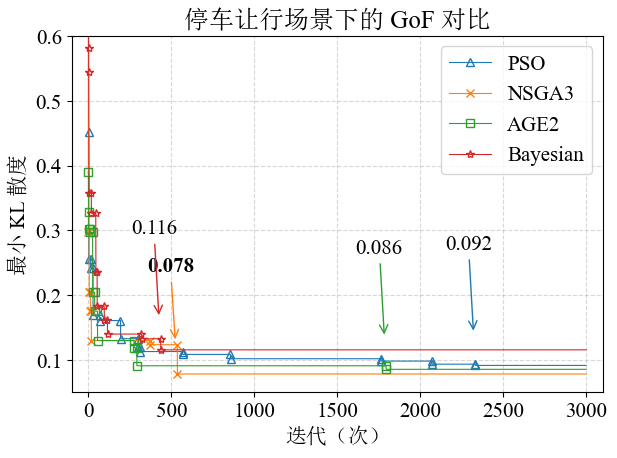

In [8]:
import numpy as np
from task import SUMO_task, pbounds
import matplotlib.pyplot as plt
import pickle
from multi_object_optimization import MooSUMOProblem, SinSUMOProblem
import pandas as pd
from matplotlib.font_manager import FontProperties
import itertools
from util import json2pd
%matplotlib inline

plt.rcParams['font.size'] = 15 
plt.rcParams['font.family'] = ['Times New Roman','SimSun']
plt.rcParams['font.weight'] = 'light'
plt.rcParams['axes.unicode_minus'] = False  
algo = ["pso", "nsga3", "age2"]
SAVED_PATH = "../output/plot/iteration"


def plot_object_f(env, algo_list, title=None):
    markers = itertools.cycle(('^', 'x', 's', '*', 'h', 'H', 'D', 'd'))
    marker_size = 6
    line_styles = itertools.cycle((':', '--', '-.', '-'))
    plt.figure(figsize=(4.0, 3.5))
    fig, ax = plt.subplots()
    
    min_points = []  # 存储每个算法的最小值点
    lines = []       # 存储每个算法对应的绘图线对象，用以获取颜色

    for algo in algo_list:
        with open(f'../output/data_cache/{env}_{algo}.pkl', 'rb') as f:
            res = pickle.load(f)
            history = res.history
            F_list = [entry.pop.get('F') for entry in history]
            all_F = np.vstack(F_list)
            df = pd.DataFrame(all_F, columns=[f'target{i}' for i in range(all_F.shape[1])])
            df['mean_targets'] = df.mean(axis=1)
            turning_points = df['mean_targets'].cummin()
            
            # 记录最小值点
            min_idx = turning_points.idxmin()
            min_val = turning_points.min()
            min_points.append((min_idx, min_val, algo.upper()))

            # 绘制曲线并存储线对象
            line, = plt.plot(df.index, turning_points, label=f'{algo.upper()}', marker=next(markers), 
                             markersize=marker_size, markerfacecolor='none', 
                             markevery=[i for i in range(1, len(turning_points) - 1) 
                                        if turning_points[i] != turning_points[i - 1] 
                                        or turning_points[i] != turning_points[i + 1]], 
                             linewidth=0.8)
            lines.append(line)

    # 添加 Bayesian 算法的结果
    df = json2pd(f'../log/{env}.log')
    df["cummax_target"] = df["target"].cummax()
    bayesian_min_idx = (-df["cummax_target"]).idxmin()
    bayesian_min_val = (-df["cummax_target"]).min()
    min_points.append((bayesian_min_idx, bayesian_min_val, "Bayesian"))

    bayesian_line, = plt.plot(df.index, -df["cummax_target"], label="Bayesian", marker=next(markers), 
                              markerfacecolor='none', 
                              markevery=[i for i in range(1, len(df["cummax_target"]) - 1) 
                                         if df["cummax_target"].iloc[i] != df["cummax_target"].iloc[i - 1] 
                                         or df["cummax_target"].iloc[i] != df["cummax_target"].iloc[i + 1]], 
                              markersize=marker_size, linewidth=0.8)
    lines.append(bayesian_line)

    # 找出全局最小值点
    global_min = min(min_points, key=lambda x: x[1])
    
    # 为每个算法的最小值添加标注和箭头
    for i, (x, y, algo_name) in enumerate(min_points):
        arrow_color = lines[i].get_color()  # 动态获取对应曲线的颜色
        if (x, y) == (global_min[0], global_min[1]):  # 全局最小值点使用不同的样式
            plt.annotate(f'{y:.3f}',
                        xy=(x, y), xycoords='data',
                        xytext=(-5, 70), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color=arrow_color,shrinkB=25, lw=1.),  
                        ha='center', va='bottom', fontweight='bold')
        else:
            plt.annotate(f'{y:.3f}',
                        xy=(x, y), xycoords='data',
                        xytext=(-5, 80), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color=arrow_color, lw=1,shrinkB=25), 
                        ha='center', va='bottom')

    plt.ylim(0.05, 0.6)
    plt.xlim(-100, 3100)
    plt.legend(loc='upper right')
    plt.title(f'{title.upper()}场景下的 GoF 对比')
    plt.xlabel('迭代（次）')
    plt.ylabel('最小 KL 散度')

    plt.tight_layout(pad=1)
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    
    plt.savefig(f'{SAVED_PATH}/{env}_comparison.pdf', dpi=300)
    plt.show()


plot_object_f("merge", algo, "汇流")
plot_object_f("right", algo, "窄路")
plot_object_f("stop", algo, "停车让行")


## 不同场景下各算法收敛性能对比 $\LaTeX$ 表 

In [9]:
import numpy as np
import pickle
import pandas as pd
from util import json2pd
import os

def load_and_analyze_data_extended(env_list, algo_list):
    """
    加载并分析不同算法在不同场景下的收敛性能，包含扩展统计量
    
    参数:
    env_list: 场景列表，如 ["merge", "right", "stop"]
    algo_list: 算法列表，如 ["pso", "nsga3", "age2"]
    
    返回:
    results_df: 包含各算法在各场景下收敛性能的DataFrame
    """
    results = []
    
    env_name_map = {
        "merge": "汇流",
        "right": "窄路",
        "stop": "停车让行"
    }
    
    for env in env_list:
        try:
            bayesian_df = json2pd(f'../log/{env}.log')
            bayesian_df["cummax_target"] = bayesian_df["target"].cummax()
            bayesian_min_idx = (-bayesian_df["cummax_target"]).idxmin()
            bayesian_min_val = -bayesian_df["cummax_target"].min()
            bayesian_iterations = len(bayesian_df)
            initial_kl = -bayesian_df["cummax_target"].iloc[0]
            
            # 1. 收敛速率
            convergence_rate = (initial_kl - bayesian_min_val) / max(1, bayesian_min_idx)
            
            # 2. 稳定性指标 (最后100次迭代的标准差)
            if len(bayesian_df) > 100:
                stability = bayesian_df["cummax_target"].iloc[-100:].std()
            else:
                stability = bayesian_df["cummax_target"].std()
            
            # 3. 初始收敛速度 (前100次迭代)
            early_iterations = min(100, len(bayesian_df))
            if early_iterations > 1:
                early_values = -bayesian_df["cummax_target"].iloc[:early_iterations]
                early_convergence = (early_values.iloc[0] - early_values.iloc[-1]) / early_iterations
            else:
                early_convergence = 0
            
            # 4. 相对改进率
            if initial_kl > 0:
                relative_improvement = (initial_kl - bayesian_min_val) / initial_kl * 100
            else:
                relative_improvement = 0
            
            results.append({
                "场景": env_name_map.get(env, env),
                "算法": "Bayesian",
                "最小KL散度": bayesian_min_val,
                "收敛迭代次数": bayesian_min_idx,
                "总迭代次数": bayesian_iterations,
                "收敛效率": bayesian_min_idx / bayesian_iterations,
                "收敛速率": convergence_rate,
                "稳定性指标": stability,
                "初始收敛速度": early_convergence,
                "相对改进率(%)": relative_improvement
            })
        except Exception as e:
            print(f"无法加载Bayesian算法在{env}场景的数据: {e}")
        
        # 处理其他算法
        for algo in algo_list:
            try:
                with open(f'../output/data_cache/{env}_{algo}.pkl', 'rb') as f:
                    res = pickle.load(f)
                    history = res.history
                    F_list = [entry.pop.get('F') for entry in history]
                    all_F = np.vstack(F_list)
                    df = pd.DataFrame(all_F, columns=[f'target{i}' for i in range(all_F.shape[1])])
                    df['mean_targets'] = df.mean(axis=1)
                    turning_points = df['mean_targets'].cummin()
                    
                    # 基本指标
                    min_idx = turning_points.idxmin()
                    min_val = turning_points.min()
                    total_iterations = len(turning_points)
                    initial_kl = turning_points.iloc[0]
                    
                    # 扩展指标
                    # 1. 收敛速率
                    convergence_rate = (initial_kl - min_val) / max(1, min_idx)
                    
                    # 2. 稳定性指标 (最后100次迭代的标准差)
                    if len(turning_points) > 100:
                        stability = turning_points.iloc[-100:].std()
                    else:
                        stability = turning_points.std()
                    
                    # 3. 初始收敛速度 (前100次迭代)
                    early_iterations = min(100, len(turning_points))
                    if early_iterations > 1:
                        early_values = turning_points.iloc[:early_iterations]
                        early_convergence = (early_values.iloc[0] - early_values.iloc[-1]) / early_iterations
                    else:
                        early_convergence = 0
                    
                    # 4. 相对改进率
                    if initial_kl > 0:
                        relative_improvement = (initial_kl - min_val) / initial_kl * 100
                    else:
                        relative_improvement = 0
                    
                    results.append({
                        "场景": env_name_map.get(env, env),
                        "算法": algo.upper(),
                        "最小KL散度": min_val,
                        "收敛迭代次数": min_idx,
                        "总迭代次数": total_iterations,
                        "收敛效率": min_idx / total_iterations,
                        "收敛速率": convergence_rate,
                        "稳定性指标": stability,
                        "初始收敛速度": early_convergence,
                        "相对改进率(%)": relative_improvement
                    })
            except Exception as e:
                print(f"无法加载{algo}算法在{env}场景的数据: {e}")
    
    results_df = pd.DataFrame(results)
    return results_df

def generate_extended_latex_table(results_df, selected_metrics):
    """
    生成包含扩展统计量的LaTeX格式三线表
    
    参数:
    results_df: 包含结果的DataFrame
    selected_metrics: 要包含在表格中的指标列表
    
    返回:
    latex_code: LaTeX表格代码
    """
    # 对数据进行排序和处理
    results_df = results_df.sort_values(by=["场景", "最小KL散度"])
    
    # 为每个场景标记最佳算法
    best_per_scene = results_df.groupby("场景")["最小KL散度"].idxmin()
    results_df["是否最佳"] = False
    results_df.loc[best_per_scene, "是否最佳"] = True
    
    # 格式化数值
    format_dict = {
        "最小KL散度": lambda x: f"{x:.4f}",
        "收敛迭代次数": lambda x: f"{int(x)}",
        "总迭代次数": lambda x: f"{int(x)}",
        "收敛效率": lambda x: f"{x:.2f}",
        "收敛速率": lambda x: f"{x:.5f}",
        "稳定性指标": lambda x: f"{x:.5f}",
        "初始收敛速度": lambda x: f"{x:.5f}",
        "相对改进率(%)": lambda x: f"{x:.1f}"
    }
    
    for metric in selected_metrics:
        if metric in format_dict:
            results_df[metric] = results_df[metric].apply(format_dict[metric])
    
    # 生成表头
    column_count = len(selected_metrics) + 2  # +2 for 场景 and 算法
    tabular_format = "c" * column_count
    
    latex_code = f"""
\\begin{{table}}[h]
    \\centering
    \\renewcommand{{\\arraystretch}}{{1.5}}
    \\setlength{{\\tabcolsep}}{{8pt}} %调整宽度
    \\bicaption{{不同场景下各算法收敛性能对比}}{{Convergence Performance Comparison of Different Algorithms in Various Scenarios}}
    \\label{{tab:convergence_comparison_extended}}
    \\begin{{tabular}}{{{tabular_format}}}
    \\toprule[1.5pt]
    场景 & 算法"""
    
    # 添加表头的指标名称
    for metric in selected_metrics:
        latex_code += f" & {metric}"
    
    latex_code += " \\\\\n    \\midrule[0.75pt]\n"
    
    current_scene = None
    scene_count = 0
    
    for _, row in results_df.iterrows():
        if current_scene != row["场景"]:
            if current_scene is not None:
                latex_code += r"    \midrule[0.75pt]" + "\n"
            current_scene = row["场景"]
            scene_count = 0
        
        # 为最佳算法添加加粗标记
        if row["是否最佳"]:
            algo_str = r"\textbf{" + row["算法"] + r"}"
        else:
            algo_str = row["算法"]
        
        # 使用multirow合并场景单元格
        if scene_count == 0:
            scene_cell = r"\multirow{4}{*}{" + row['场景'] + r"}"
        else:
            scene_cell = ""
        
        latex_code += f"    {scene_cell} & {algo_str}"
        
        for metric in selected_metrics:
            value = row[metric]
            if metric == "最小KL散度" and row["是否最佳"]:
                value = r"\textbf{" + value + r"}"
            latex_code += f" & {value}"
        
        latex_code += " \\\\\n"
        scene_count += 1
    
    latex_code += r"""    \bottomrule[1.5pt]  
    \end{tabular}
\end{table}
"""
    return latex_code

# 主函数
def main():
    env_list = ["merge", "right", "stop"]
    algo_list = ["pso", "nsga3", "age2"]
    
    # 分析算法总体收敛性能，包含扩展统计量
    print("加载数据...")
    results_df = load_and_analyze_data_extended(env_list, algo_list)
    
    # 生成不同组合的表格
    # 表格1: 基本指标
    basic_metrics = ["最小KL散度", "收敛迭代次数", "收敛效率"]
    latex_table_basic = generate_extended_latex_table(results_df, basic_metrics)
    
    # 表格2: 收敛速度相关指标
    speed_metrics = ["最小KL散度", "收敛速率", "初始收敛速度"]
    latex_table_speed = generate_extended_latex_table(results_df, speed_metrics)
    
    # 表格3: 稳定性和改进率
    stability_metrics = ["最小KL散度", "稳定性指标", "相对改进率(%)"]
    latex_table_stability = generate_extended_latex_table(results_df, stability_metrics)
    
    # 表格4: 综合指标
    comprehensive_metrics = ["最小KL散度", "收敛迭代次数", "初始收敛速度", "收敛效率"]
    latex_table_comprehensive = generate_extended_latex_table(results_df, comprehensive_metrics)
    
    return latex_table_basic, latex_table_speed, latex_table_stability, latex_table_comprehensive

# 执行主函数
if __name__ == "__main__":
    latex_table_basic, latex_table_speed, latex_table_stability, latex_table_comprehensive = main()
    print(latex_table_comprehensive)
    print("LaTeX表格已生成")


加载数据...

\begin{table}[h]
    \centering
    \renewcommand{\arraystretch}{1.5}
    \setlength{\tabcolsep}{8pt} %调整宽度
    \bicaption{不同场景下各算法收敛性能对比}{Convergence Performance Comparison of Different Algorithms in Various Scenarios}
    \label{tab:convergence_comparison_extended}
    \begin{tabular}{cccccc}
    \toprule[1.5pt]
    场景 & 算法 & 最小KL散度 & 收敛迭代次数 & 初始收敛速度 & 收敛效率 \\
    \midrule[0.75pt]
    \multirow{4}{*}{停车让行} & \textbf{NSGA3} & \textbf{0.0784} & 537 & 0.00555 & 0.18 \\
     & AGE2 & 0.0856 & 1795 & 0.00260 & 0.60 \\
     & PSO & 0.0917 & 2332 & 0.00290 & 0.78 \\
     & Bayesian & 0.6669 & 437 & 0.00506 & 0.15 \\
    \midrule[0.75pt]
    \multirow{4}{*}{汇流} & \textbf{AGE2} & \textbf{0.0870} & 2682 & 0.00149 & 0.89 \\
     & NSGA3 & 0.1069 & 2027 & 0.00149 & 0.68 \\
     & PSO & 0.1162 & 2383 & 0.00198 & 0.79 \\
     & Bayesian & 0.3588 & 2978 & 0.00138 & 0.99 \\
    \midrule[0.75pt]
    \multirow{4}{*}{窄路} & \textbf{AGE2} & \textbf{0.0798} & 2694 & 0.00037 & 0.90 \\
     & NSGA3

## 多目标算法性能指标收敛速度比较图

<Figure size 750x600 with 0 Axes>

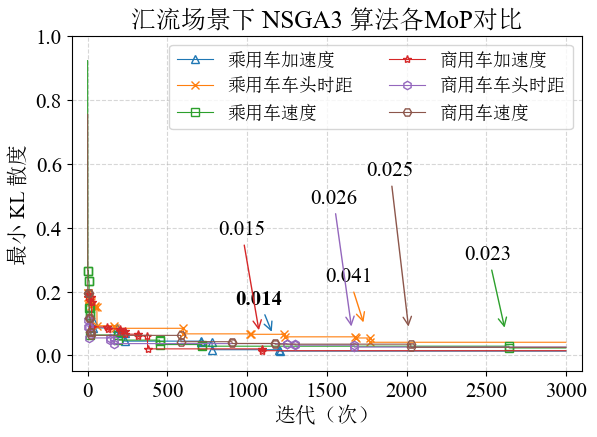

<Figure size 750x600 with 0 Axes>

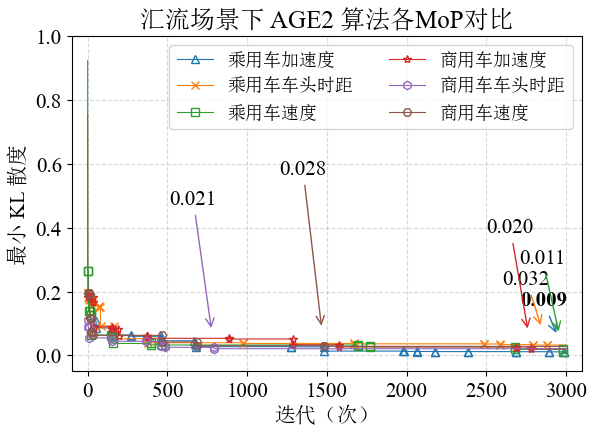

<Figure size 750x600 with 0 Axes>

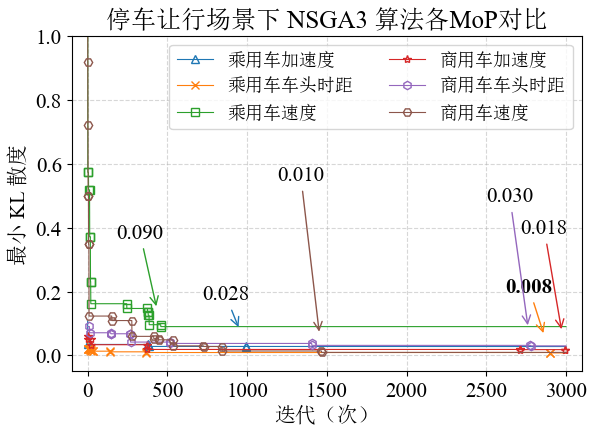

<Figure size 750x600 with 0 Axes>

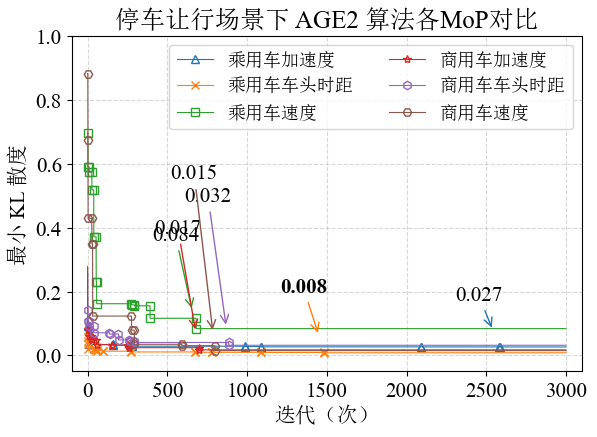

<Figure size 750x600 with 0 Axes>

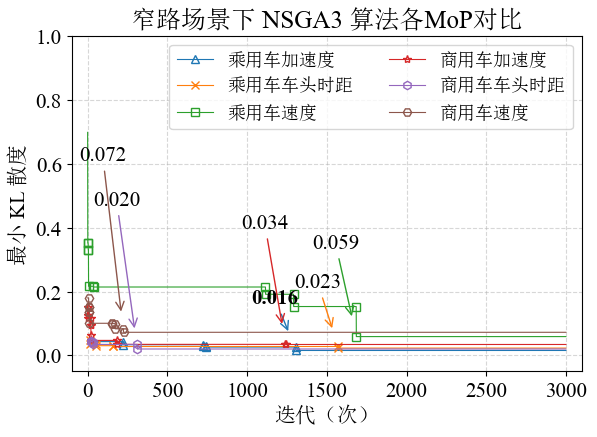

<Figure size 750x600 with 0 Axes>

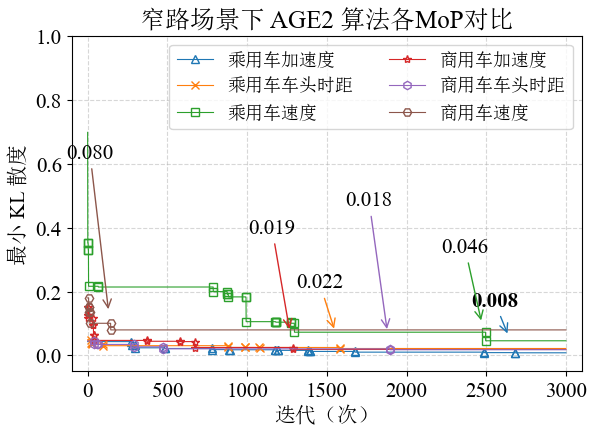

In [10]:
import numpy as np
from task import SUMO_task, pbounds  
import matplotlib.pyplot as plt
import pickle
from multi_object_optimization import MooSUMOProblem, SinSUMOProblem  # 假设这些模块存在且可用
import pandas as pd
import itertools

plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = ["Times New Roman", "SimSun"]
plt.rcParams["font.serif"] = ["Times New Roman", "SimSun"]
plt.rcParams["font.sans-serif"] = ["Times New Roman", "SimSun"]
plt.rcParams["mathtext.fontset"] = "custom"

SAVED_PATH = "../output/plot/iteration"


def plot_object_f(env, algo):
    # 中文标签映射
    name_map = {
        'Car acc': '乘用车加速度',
        'Car dhw': '乘用车车头时距',
        'Car v': '乘用车速度',
        'Bus acc': '商用车加速度',
        'Bus dhw': '商用车车头时距',
        'Bus v': '商用车速度'
    }

    markers = itertools.cycle(('^', 'x', 's', '*', 'h', 'H', 'D', 'd'))
    marker_size = 6
    line_styles = itertools.cycle((':', '--', '-.', '-'))
    plt.figure(figsize=(7.5, 6))  # 调整图像大小
    fig, ax = plt.subplots()

    try:
        with open(f'../output/data_cache/{env}_{algo}.pkl', 'rb') as f:
            res = pickle.load(f)
    except FileNotFoundError:
        print(f"未找到文件: ../output/data_cache/{env}_{algo}.pkl")
        return
    
    history = res.history
    F_list = [entry.pop.get('F') for entry in history]
    all_F = np.vstack(F_list)
    target_names = ['Car acc', 'Car dhw', 'Car v', 'Bus acc', 'Bus dhw', 'Bus v']
    df = pd.DataFrame(all_F, columns=target_names)

    lines = []  # 用于存储线条对象，以便后续获取颜色
    min_points = []  # 存储每个指标的最小值的坐标和标签

    for target in target_names:
        turning_points = df[target].cummin()
        line, = plt.plot(df.index, turning_points, label=name_map.get(target, target),
                         marker=next(markers),
                         markersize=marker_size,
                         markerfacecolor='none',
                         markevery=[i for i in range(1, len(turning_points) - 1)
                                    if turning_points[i] != turning_points[i - 1]
                                    or turning_points[i] != turning_points[i + 1]],
                         linewidth=0.8)
        lines.append(line)

        # 找到最小值点并添加到 min_points 列表
        min_idx = turning_points.idxmin()
        min_val = turning_points.min()
        min_points.append((min_idx, min_val, name_map.get(target, target)))

    global_min = min(min_points, key=lambda x: x[1])

    # 添加标注和箭头
    for i, (x, y, label) in enumerate(min_points):
        arrow_color = lines[i].get_color() # 获取对应曲线的颜色

        hight = [30,40,60,80,100, 120]
        if (x, y) == (global_min[0], global_min[1]):
            plt.annotate(f'{y:.3f}',
                        xy=(x, y), xycoords='data',
                        xytext=(-15,hight[i]), textcoords='offset points',  # 调整标注位置
                        arrowprops=dict(arrowstyle="->", color=arrow_color, lw=1, shrinkB=15),
                        ha='center', va='bottom', fontweight='bold')
        else:
            plt.annotate(f'{y:.3f}',
                        xy=(x, y), xycoords='data',
                        xytext=(-15,hight[i]), textcoords='offset points',  # 调整标注位置
                        arrowprops=dict(arrowstyle="->", color=arrow_color, lw=1, shrinkB=15),
                        ha='center', va='bottom')

    plt.ylim(-0.05, 1)  #调整y轴
    plt.xlim(-100, 3100)
    plt.legend(loc='upper right',fontsize=13,ncol=2)  # 添加图例

    # 根据环境设置标题
    title_map = {
        "merge": "汇流",
        "stop": "停车让行",
        "right": "窄路"
    }
    title_zh = title_map.get(env, env.upper())  # 获取中文标题，如果没有则使用英文大写

    plt.title(f'{title_zh}场景下 {algo.upper()} 算法各MoP对比')  # 使用中文标题
    plt.xlabel('迭代（次）')
    plt.ylabel('最小 KL 散度')

    plt.tight_layout(pad=1.5)  # 调整布局
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    plt.savefig(f'{SAVED_PATH}/{env}_{algo}_object_f.pdf', dpi=300)
    plt.show()


algo_list = ["nsga3", "age2"]
envs = ["merge", "stop", "right"]
for env in envs:
    for algo in algo_list:
        plot_object_f(env, algo)

## 不同场景和算法下各性能指标的最小 KL 散度值表

In [11]:
import numpy as np
import pickle
import pandas as pd
import os

def extract_data_and_generate_latex():
    envs = ["merge", "stop", "right"]
    algo_list = ["nsga3", "age2"]
    
    # 中文标签映射
    name_map = {
        'Car acc': '乘用车加速度',
        'Car dhw': '乘用车车头时距',
        'Car v': '乘用车速度',
        'Bus acc': '商用车加速度',
        'Bus dhw': '商用车车头时距',
        'Bus v': '商用车速度'
    }
    
    # 英文标签映射
    eng_map = {
        'Car acc': 'Car Acceleration',
        'Car dhw': 'Car Headway',
        'Car v': 'Car Velocity',
        'Bus acc': 'Bus Acceleration',
        'Bus dhw': 'Bus Headway',
        'Bus v': 'Bus Velocity'
    }
    
    # 场景映射
    env_map = {
        "merge": "汇流场景",
        "stop": "停车让行场景",
        "right": "窄路场景"
    }
    
    env_map_eng = {
        "merge": "Merge Scenario",
        "stop": "Stop Yield Scenario",
        "right": "Narrow Road Scenario"
    }
    
    # 算法映射
    algo_map = {
        "nsga3": "NSGA-III",
        "age2": "AGE-II"
    }
    
    # 创建结果存储结构
    results = {}
    target_names = ['Car acc', 'Car dhw', 'Car v', 'Bus acc', 'Bus dhw', 'Bus v']
    
    # 提取数据
    for env in envs:
        results[env] = {}
        for algo in algo_list:
            try:
                with open(f'../output/data_cache/{env}_{algo}.pkl', 'rb') as f:
                    res = pickle.load(f)
                    
                history = res.history
                F_list = [entry.pop.get('F') for entry in history]
                all_F = np.vstack(F_list)
                df = pd.DataFrame(all_F, columns=target_names)
                
                # 计算每个指标的最小值
                min_values = {}
                for target in target_names:
                    turning_points = df[target].cummin()
                    min_val = turning_points.min()
                    min_values[target] = min_val
                
                results[env][algo] = min_values
                
            except FileNotFoundError:
                print(f"未找到文件: ../output/data_cache/{env}_{algo}.pkl")
                results[env][algo] = {target: "N/A" for target in target_names}
    
    # 找出每个指标的全局最小值
    global_min = {}
    for target in target_names:
        min_val = float('inf')
        for env in envs:
            for algo in algo_list:
                if isinstance(results[env][algo][target], (int, float)) and results[env][algo][target] < min_val:
                    min_val = results[env][algo][target]
        global_min[target] = min_val
    
    # 生成LaTeX表格
    latex_code = r'''\begin{table}[h]
    \centering
    \renewcommand{\arraystretch}{1.5}
    \setlength{\tabcolsep}{10pt} %调整宽度
    \bicaption{不同场景和算法下各指标的最小KL散度值}{Minimum KL Divergence Values for Different Scenarios and Algorithms}
    \label{tab:kl_divergence}
    \begin{tabular}{ccccccccc}
    \toprule[1.5pt]
    \multirow{2}{*}{场景} & \multirow{2}{*}{算法} & \multicolumn{3}{c}{乘用车} & \multicolumn{3}{c}{商用车} \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8}
    & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\
    \midrule[0.75pt]'''
    
    # 添加数据行
    for env in envs:
        for i, algo in enumerate(algo_list):
            if i == 0:
                row = f"\n    \\multirow{{2}}{{*}}{{{env_map[env]}}} & {algo_map[algo]}"
            else:
                row = f"\n    & {algo_map[algo]}"
                
            for target in ['Car acc', 'Car dhw', 'Car v', 'Bus acc', 'Bus dhw', 'Bus v']:
                if isinstance(results[env][algo][target], (int, float)):
                    # 如果是最小值，则加粗显示
                    if abs(results[env][algo][target] - global_min[target]) < 1e-6:  # 使用小误差范围比较浮点数
                        row += f" & \\textbf{{{results[env][algo][target]:.3f}}}"
                    else:
                        row += f" & {results[env][algo][target]:.3f}"
                else:
                    row += f" & {results[env][algo][target]}"
            
            latex_code += row + " \\\\"
            
        if env != envs[-1]:
            latex_code += "\n    \\midrule"
    
    # 完成表格
    latex_code += r'''
    \bottomrule[1.5pt]  
    \end{tabular}
\end{table}'''
    
    return latex_code

# 执行函数并打印结果
latex_table = extract_data_and_generate_latex()
print(latex_table)


\begin{table}[h]
    \centering
    \renewcommand{\arraystretch}{1.5}
    \setlength{\tabcolsep}{10pt} %调整宽度
    \bicaption{不同场景和算法下各指标的最小KL散度值}{Minimum KL Divergence Values for Different Scenarios and Algorithms}
    \label{tab:kl_divergence}
    \begin{tabular}{ccccccccc}
    \toprule[1.5pt]
    \multirow{2}{*}{场景} & \multirow{2}{*}{算法} & \multicolumn{3}{c}{乘用车} & \multicolumn{3}{c}{商用车} \\
    \cmidrule(lr){3-5} \cmidrule(lr){6-8}
    & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\
    \midrule[0.75pt]
    \multirow{2}{*}{汇流场景} & NSGA-III & 0.014 & 0.041 & 0.023 & \textbf{0.015} & 0.026 & 0.025 \\
    & AGE-II & 0.009 & 0.032 & \textbf{0.011} & 0.020 & 0.021 & 0.028 \\
    \midrule
    \multirow{2}{*}{停车让行场景} & NSGA-III & 0.028 & \textbf{0.008} & 0.090 & 0.018 & 0.030 & \textbf{0.010} \\
    & AGE-II & 0.027 & 0.008 & 0.084 & 0.017 & 0.032 & 0.015 \\
    \midrule
    \multirow{2}{*}{窄路场景} & NSGA-III & 0.016 & 0.023 & 0.059 & 0.034 & 0.020 & 0.072 \\
    & AGE-II & \textbf{0.008} & 0.022 & 

## 校准参数、真实数据与未校准 SUMO 参数的分布比较图

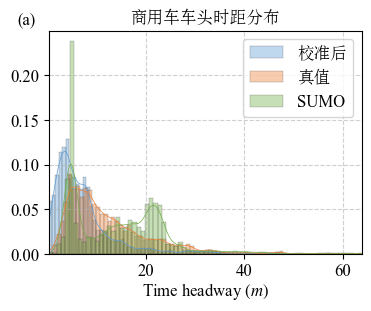

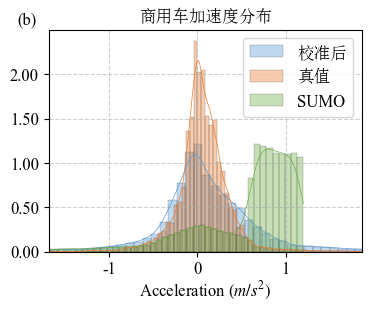

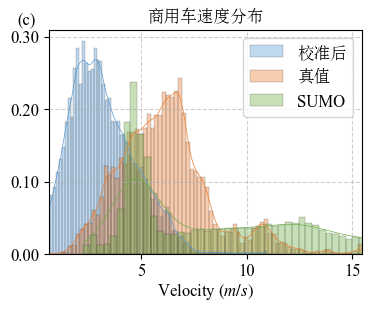

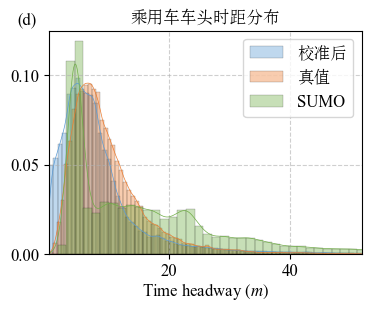

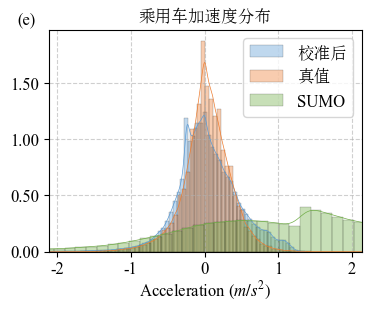

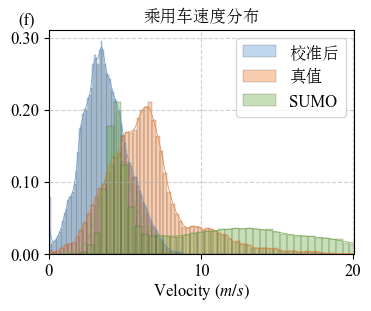

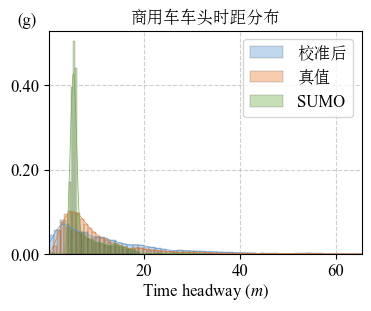

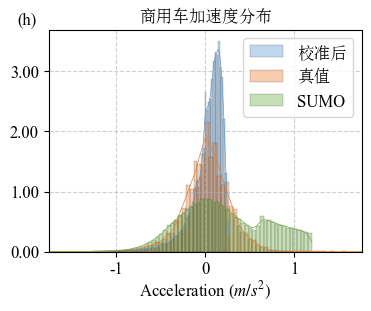

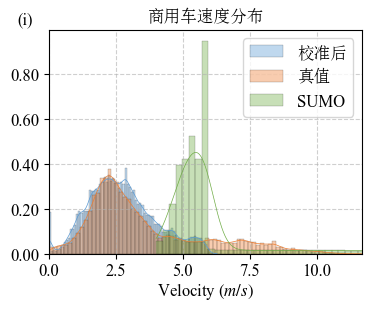

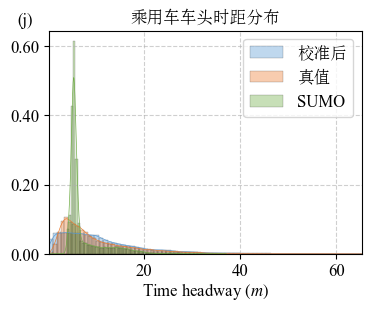

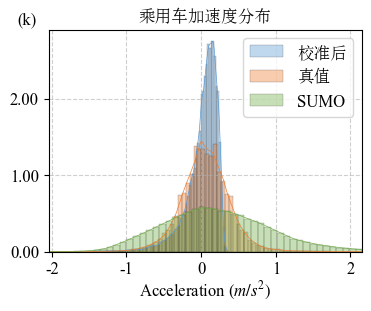

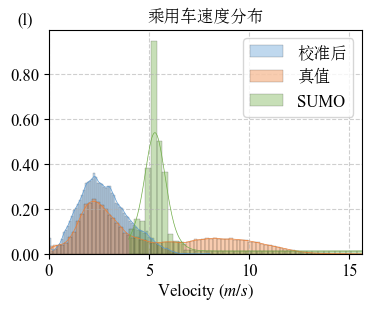

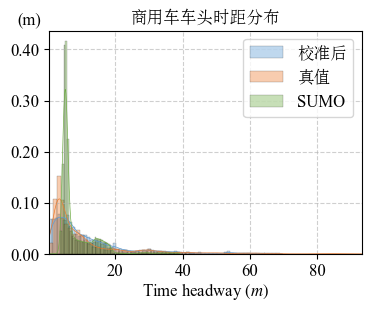

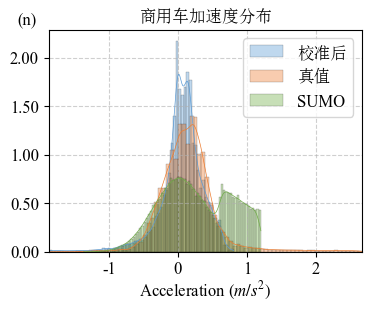

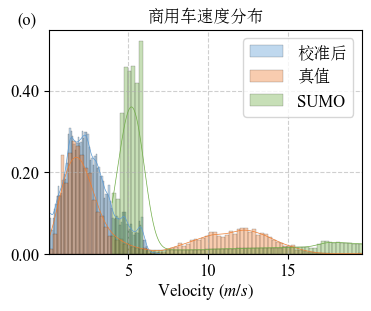

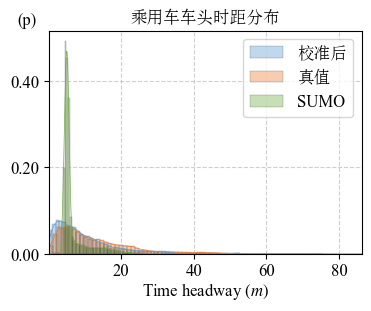

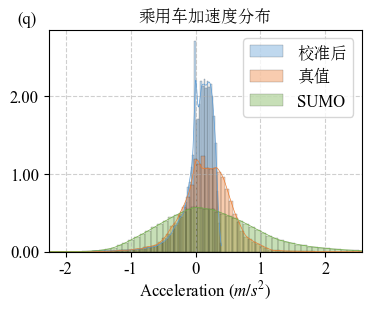

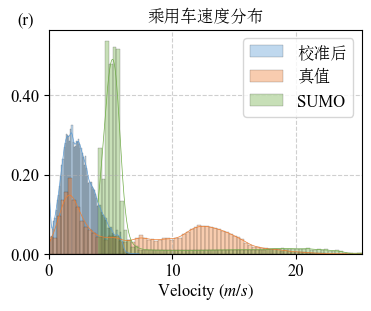

In [12]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from process_data import get_all_kl_divergence
from matplotlib.font_manager import FontProperties


plt.rcParams["font.family"] = ["Times New Roman", "SimSun"]
plt.rcParams["font.serif"] = ["Times New Roman", "SimSun"]
plt.rcParams["font.sans-serif"] = ["Times New Roman", "SimSun"]
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["mathtext.rm"] = "SimSun"
SAVED_PATH = "../output/plot/distribution"

vehicle_type_map = {
    "bus": "商用车",
    "car": "乘用车"
}

name_map = {
    "velocity": "速度",
    "acceleration": "加速度",
    "time headway": "车头时距"
}

def plot_distribution_comparison(data_list, vehicle_type, variable, output_dir, index):
    plt.figure(figsize=(3.6, 3))
    colors = ["#5b9bd5", "#ed7d31", "#70ad47"]
    labels = ["校准后", "真值", "SUMO"]

    # 绘制直方图和KDE
    for idx, (data, color) in enumerate(zip(data_list, colors)):
        hist_data, bin_width, bin_centers, kde_x, kde_y = data

        plt.bar(
            bin_centers,
            height=hist_data,
            width=bin_width,
            align="center",
            edgecolor="k",
            alpha=0.39,
            color=color,
            linewidth=0.3,
            # linecolor="grey",
            label=f"{labels[idx]}",
        )

        plt.plot(kde_x, kde_y, color=color, linestyle="-", linewidth="0.5")

    if len(data_list) > 1:
        _, _, _, kde_x_second, _ = data_list[1]
        plt.xlim(min(kde_x_second), max(kde_x_second))

    # 添加子图标号 (a), (b), ...
    subplot_label = f"({chr(97 + index)})"  # 根据index生成(a), (b), ...
    plt.text(-0.1, 1.03, subplot_label, transform=plt.gca().transAxes, fontsize=12)  # 调整 fontsize 并移除 fontweight

    # 标题与标签
    base_fontsize = 12 # 设置基础字体大小
    title_fontsize = base_fontsize # 设置标题字体大小
    
    # 使用映射获取中文名称
    vehicle_type_zh = vehicle_type_map.get(vehicle_type.lower(), vehicle_type)
    
    if variable == "xVelocity":
        plt.xlabel(f"Velocity $(m/s)$",fontsize=title_fontsize, labelpad=1)
        name = "Velocity"
        name_zh = name_map.get("velocity", "速度")
    elif variable == "xAcceleration":
        plt.xlabel(f"Acceleration $(m/s^2)$",fontsize=title_fontsize, labelpad=1)
        name = "Acceleration"
        name_zh = name_map.get("acceleration", "加速度")
    elif variable == "dhw":
        plt.xlabel(f"Time headway $(m)$",fontsize=title_fontsize, labelpad=1)   
        name = "Time headway"
        name_zh = name_map.get("time headway", "车头时距")
    
    # 使用中文标题
    plt.title(f"{vehicle_type_zh}{name_zh}分布", fontsize=title_fontsize)
    plt.legend(loc="upper right",fontsize=12) # 调整 legend 字体大小
    plt.xticks(fontsize=base_fontsize)
    plt.yticks(fontsize=base_fontsize)
    
    # 设置x轴刻度格式为小数点后2位
    from matplotlib.ticker import FormatStrFormatter
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    # plt.subplots_adjust(left=-0.1, bottom=-0.25, right=0.8, top=0.8)
    plt.tight_layout(pad=0.2)
    

    # 保存文件
    output_file = os.path.join(
        output_dir, f"{env}_{vehicle_type}_{variable}_distribution.pdf"
    )
    plt.savefig(output_file, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # plt.close()  # 修改为 plt.close() 以避免显示所有图形

def plot_distributions_from_caches(caches, output_dir, start_index=0):
    dfs = []
    for cache in caches:
        with open(cache, "rb") as f:
            dfs.append(pickle.load(f))

    hist_kde_data = [df["hist_kde_data"] for df in dfs]

    keys = set(hist_kde_data[0].keys())
    for data in hist_kde_data[1:]:
        keys.intersection_update(data.keys())

    idx = start_index  # 初始化子图序号
    for cache_key in sorted(list(keys)): # 保证顺序一致性
        vehicle_type, variable = cache_key.split("_")
        data_list = [data[cache_key] for data in hist_kde_data]
        plot_distribution_comparison(data_list, vehicle_type, variable, output_dir, idx)
        idx += 1  # 子图序号递增
    return idx # 返回下一个起始索引

# 调用绘图函数
current_index = 0
for env in ["merge", "right", "stop"]:
    current_index = plot_distributions_from_caches([f"../output/data_raw/{env}/_cache.pkl",
                                    f"../output/data_cache/{env}_cache.pkl",
                                    f"../output/data_raw/{env}_origin/_cache.pkl"
                                    ],
        SAVED_PATH, current_index
    )


## 帕累托前沿分布图

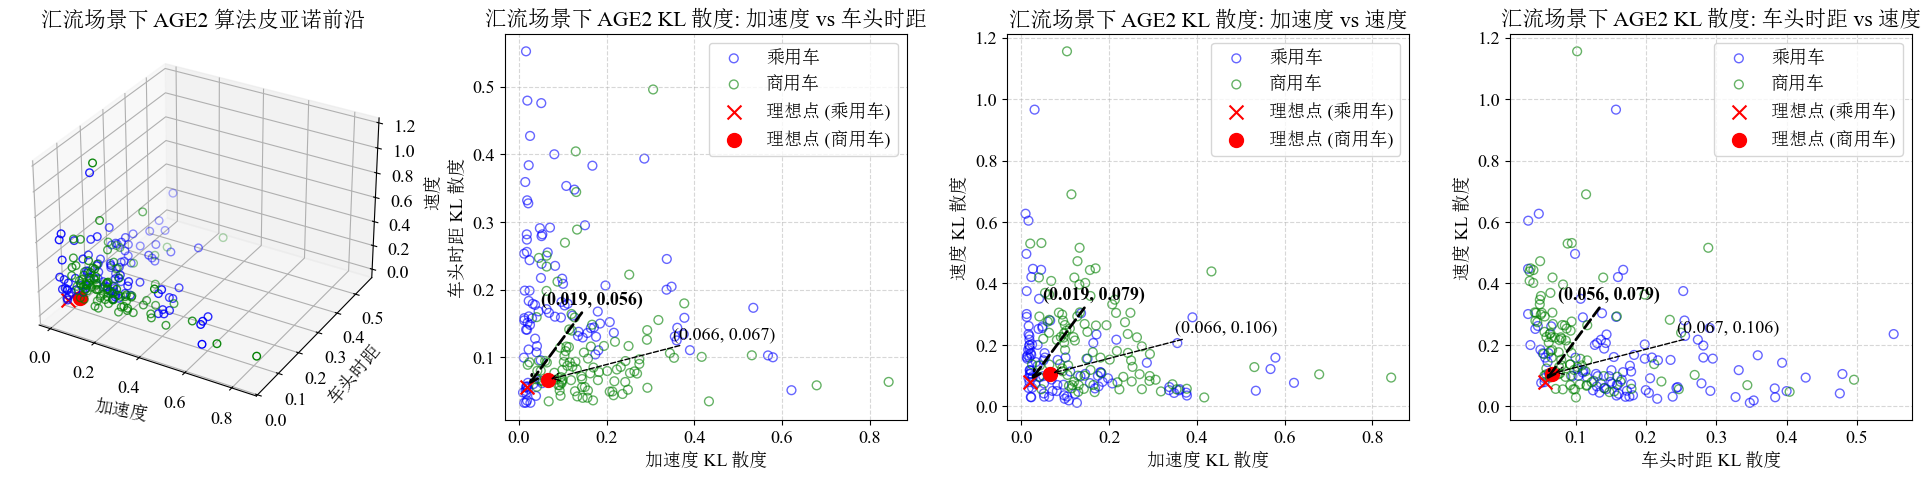

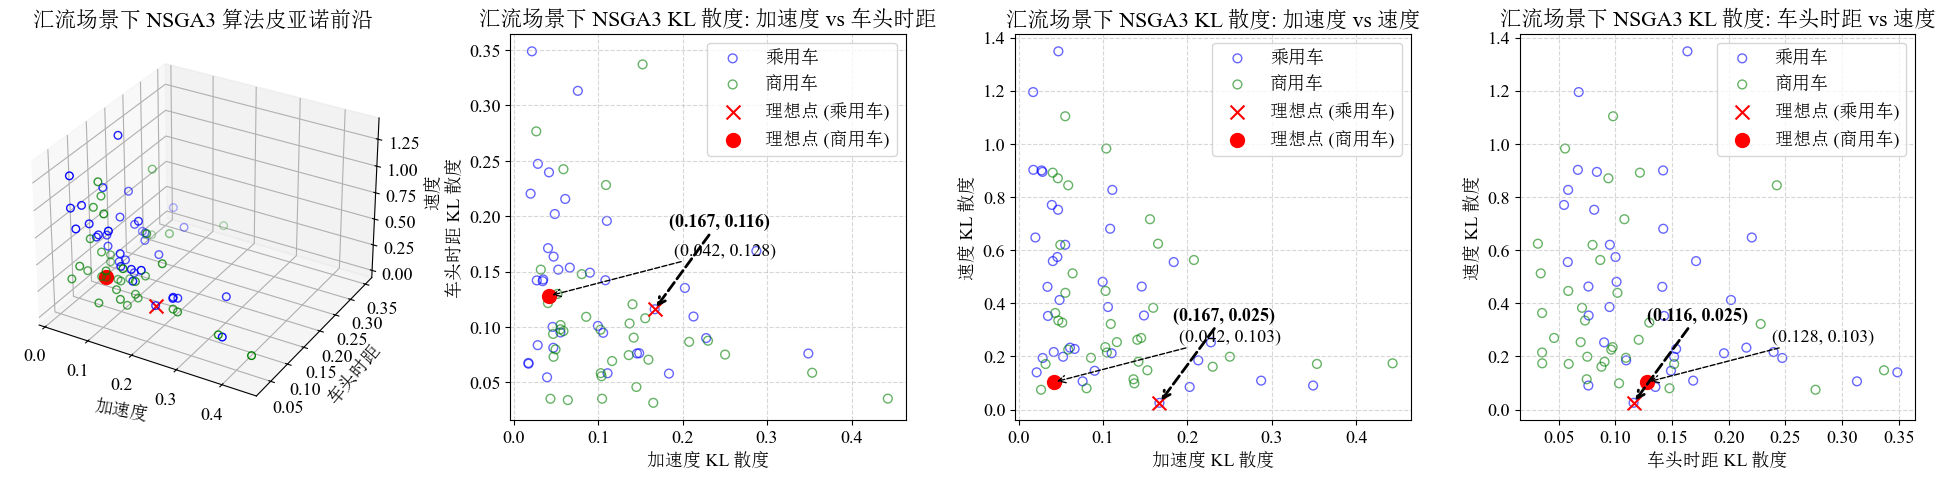

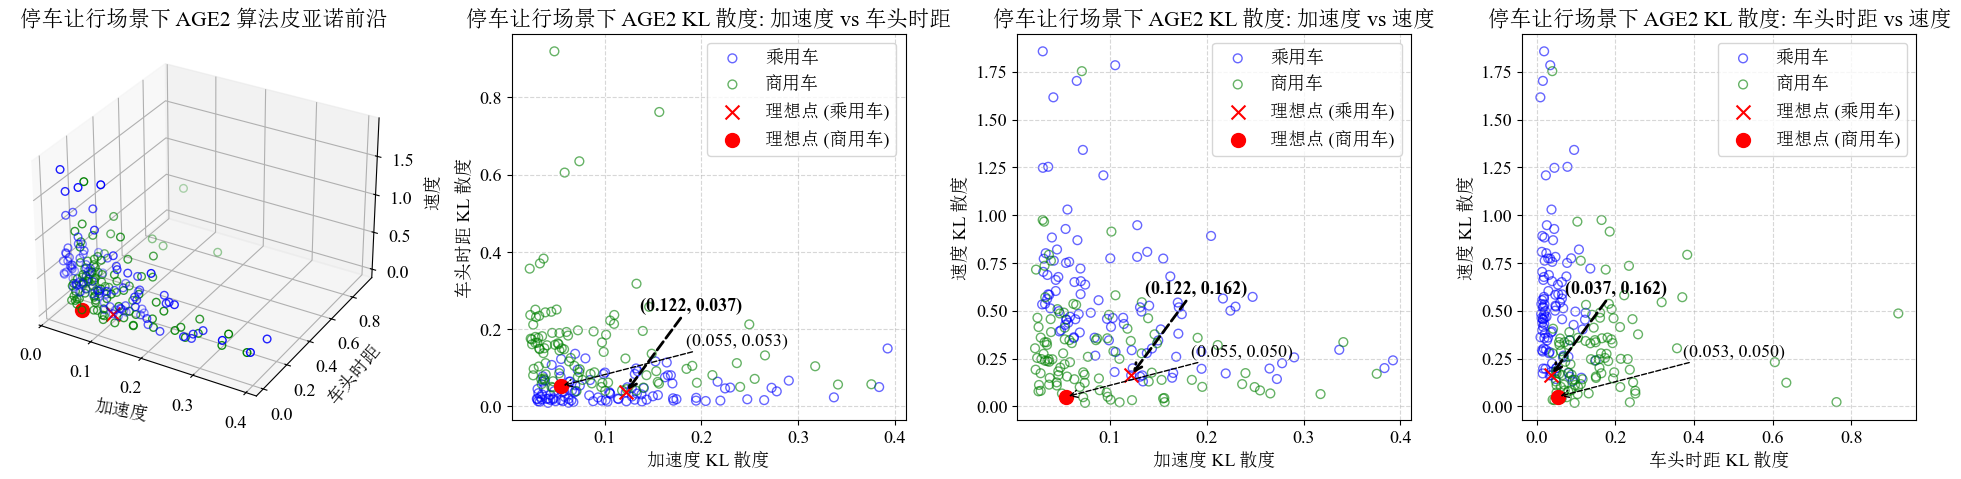

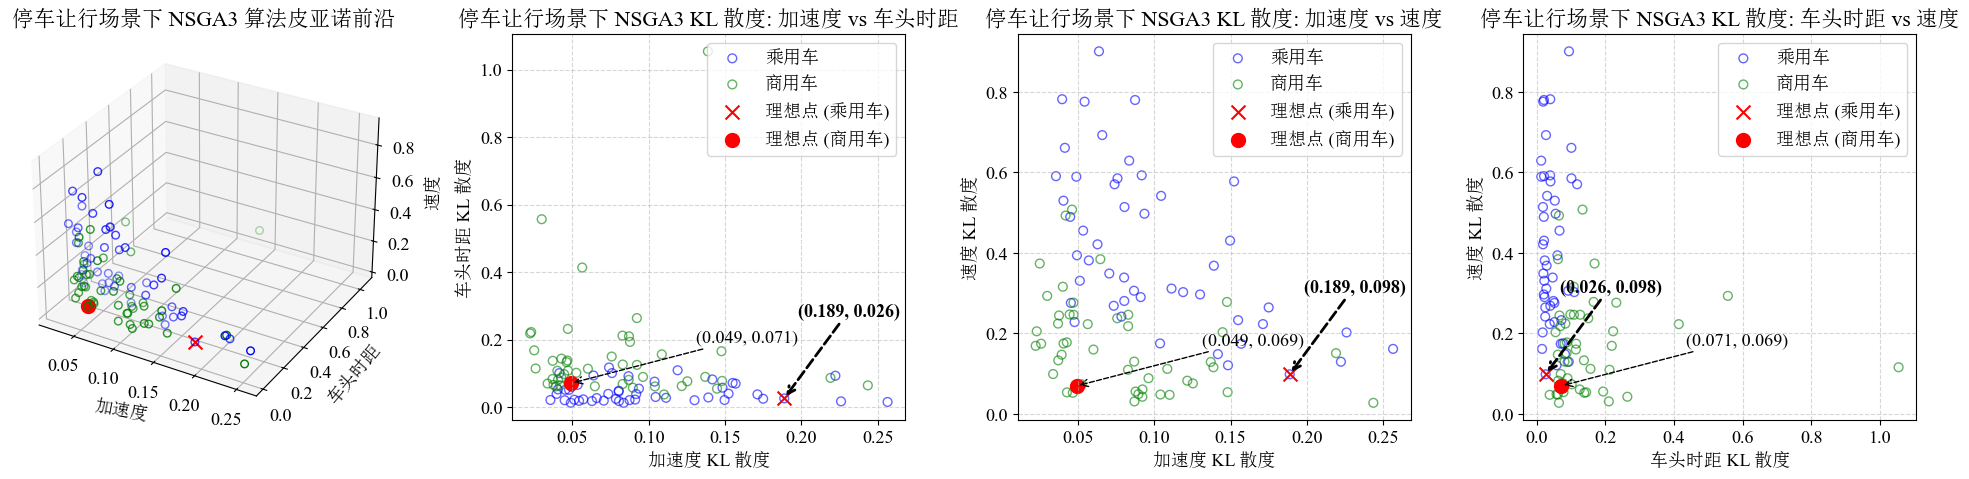

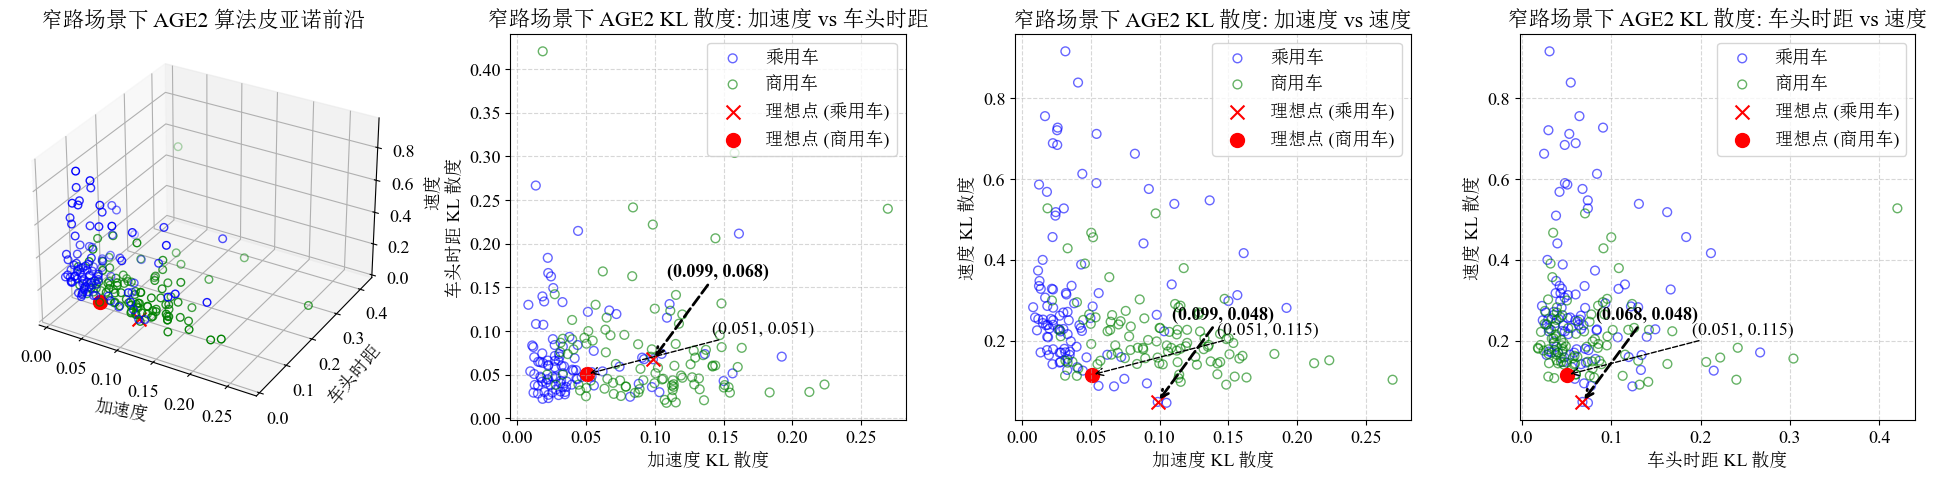

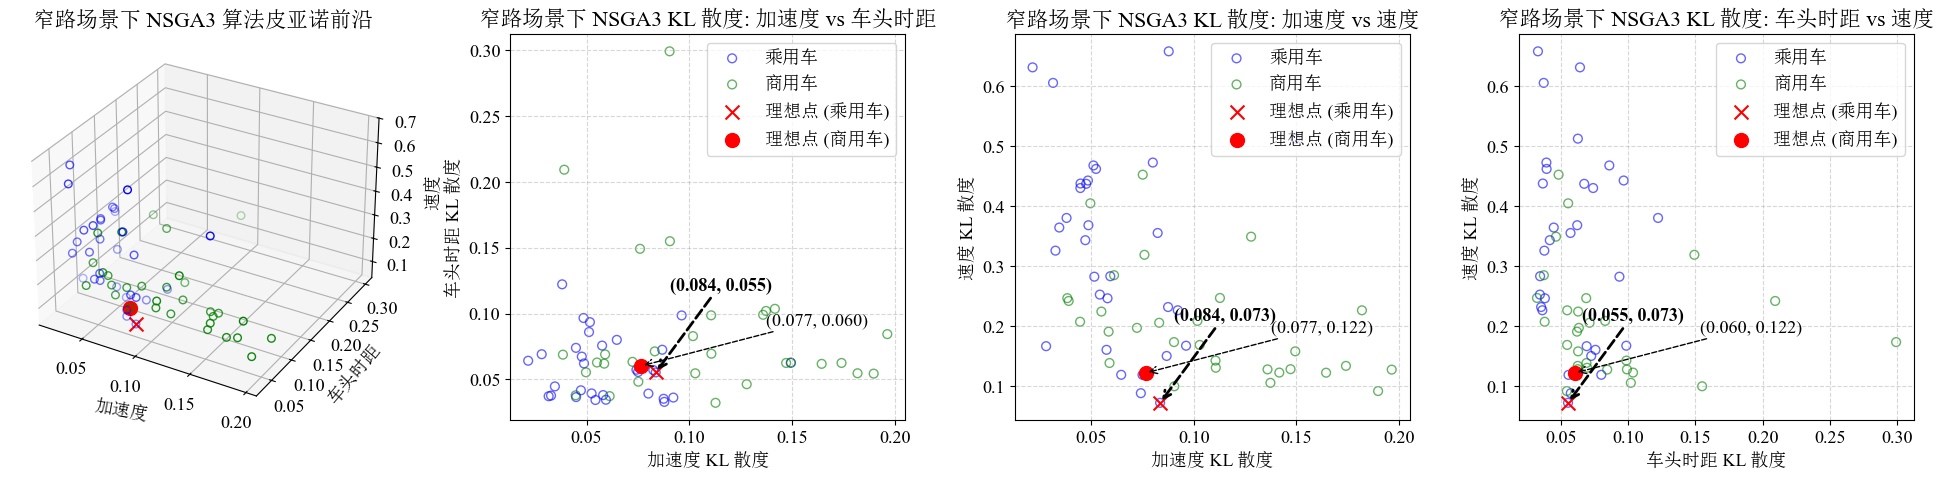

In [13]:
from multi_object_optimization import MooSUMOProblem, SinSUMOProblem

import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 中文显示设置
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = ['Times New Roman', 'SimSun']  # 同时设置 Times New Roman 和宋体
plt.rcParams['font.weight'] = 'light'
plt.rcParams['axes.unicode_minus'] = False

# 环境和算法列表
environments = ["merge", "stop", "right"]
algorithms = ["age2", "nsga3"]

# 环境名称映射
env_map = {
    "merge": "汇流",
    "stop": "停车让行",
    "right": "窄路"
}

# 特征名称映射
feature_names = {
    0: "加速度",
    1: "车头时距",
    2: "速度"
}

# 定义车辆和商用车特征索引
car_indices = [0, 1, 2]  # 乘用车特征索引: "加速度", "车头时距", "速度"
bus_indices = [3, 4, 5]  # 商用车特征索引: "加速度", "车头时距", "速度"

# 遍历环境和算法
for env in environments:
    for alg in algorithms:
        try:
            with open(f'../output/data_cache/{env}_{alg}.pkl', 'rb') as f:
                res = pickle.load(f)
                F = res.F

                # 计算乘用车和商用车的理想点
                ideal_point_index_car = np.argmin(np.sum(F[:, car_indices], axis=1))
                ideal_point_car = F[ideal_point_index_car, car_indices]
                
                ideal_point_index_bus = np.argmin(np.sum(F[:, bus_indices], axis=1))
                ideal_point_bus = F[ideal_point_index_bus, bus_indices]

                # 设置图形
                fig = plt.figure(figsize=(20, 5.5))
                
                # 获取环境的中文名称
                env_zh = env_map.get(env, env.upper())
                
                # 创建3D散点图
                # projection 选项包括: '3d', 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear'
                # '3d': 三维投影
                # 'aitoff', 'hammer', 'lambert', 'mollweide': 不同的地图投影方式
                # 'polar': 极坐标投影
                # 'rectilinear': 默认的笛卡尔坐标系投影
                ax_3d = fig.add_subplot(141, projection='3d')
                ax_3d.set_title(f'{env_zh}场景下 {alg.upper()} 算法皮亚诺前沿')
                ax_3d.set_xlabel('加速度',labelpad=5, rotation=-10)
                ax_3d.set_ylabel('车头时距',labelpad=5, rotation=50)
                ax_3d.set_zlabel('速度',labelpad=5,rotation=90)

                # 绘制乘用车数据
                ax_3d.scatter(F[:, car_indices[0]], F[:, car_indices[1]], F[:, car_indices[2]], 
                             s=30, facecolors='none', edgecolors='blue', label='乘用车')

                # 绘制商用车数据
                ax_3d.scatter(F[:, bus_indices[0]], F[:, bus_indices[1]], F[:, bus_indices[2]], 
                             s=30, facecolors='none', edgecolors='green', label='商用车')

                # 标记乘用车和商用车的理想点
                ax_3d.scatter(ideal_point_car[0], ideal_point_car[1], ideal_point_car[2], 
                             s=100, c='red', marker='x', label='理想点 (乘用车)', facecolors='white')
                ax_3d.scatter(ideal_point_bus[0], ideal_point_bus[1], ideal_point_bus[2], 
                             s=100, c='red', marker='o', label='理想点 (商用车)', facecolors='white')
                
                # 添加3D箭头标注
                # ax_3d.text(ideal_point_car[0]+10, ideal_point_car[1]+10, ideal_point_car[2]+10, 
                #           f'({ideal_point_car[0]:.3f}, {ideal_point_car[1]:.3f}, {ideal_point_car[2]:.3f})', 
                #           color='black', fontweight='bold')
                # ax_3d.text(ideal_point_bus[0], ideal_point_bus[1], ideal_point_bus[2], 
                #           f'({ideal_point_bus[0]:.3f}, {ideal_point_bus[1]:.3f}, {ideal_point_bus[2]:.3f})', 
                #           color='black')
                
                # ax_3d.legend(fontsize=13, loc="upper left")

                # 定义2D图的特征索引对
                pairs = [(0, 1), (0, 2), (1, 2)]  # 对应 (加速度, 车头时距), (加速度, 速度), (车头时距, 速度)

                # 为每对特征创建2D散点图
                for i, (x_idx, y_idx) in enumerate(pairs):
                    ax = fig.add_subplot(1, 4, i + 2)
                    ax.set_title(f'{env_zh}场景下 {alg.upper()} KL 散度: {feature_names[x_idx]} vs {feature_names[y_idx]}')
                    ax.set_xlabel(f'{feature_names[x_idx]} KL 散度')
                    ax.set_ylabel(f'{feature_names[y_idx]} KL 散度')

                    # 乘用车数据
                    ax.scatter(F[:, car_indices[x_idx]], F[:, car_indices[y_idx]], 
                              s=40, facecolors='none', edgecolors='blue', label='乘用车', alpha=0.6)

                    # 商用车数据
                    ax.scatter(F[:, bus_indices[x_idx]], F[:, bus_indices[y_idx]], 
                              s=40, facecolors='none', edgecolors='green', label='商用车', alpha=0.6)
                    ax.grid(visible=True, linestyle='--', alpha=0.5)

                    # 标记乘用车和商用车的理想点
                    ax.scatter(ideal_point_car[x_idx], ideal_point_car[y_idx], 
                              s=100, c='red', marker='x', label='理想点 (乘用车)')
                    ax.scatter(ideal_point_bus[x_idx], ideal_point_bus[y_idx], 
                              s=100, c='red', marker='o', label='理想点 (商用车)')
                    
                    # 添加箭头标注
                    ax.annotate(f'({ideal_point_car[x_idx]:.3f}, {ideal_point_car[y_idx]:.3f})',
                               xy=(ideal_point_car[x_idx], ideal_point_car[y_idx]),
                               xytext=(10, 60), textcoords='offset points',
                               arrowprops=dict(arrowstyle="->", color='black',linestyle='--', lw=2),
                               color='black', fontweight='bold')
                    
                    ax.annotate(f'({ideal_point_bus[x_idx]:.3f}, {ideal_point_bus[y_idx]:.3f})',
                               xy=(ideal_point_bus[x_idx], ideal_point_bus[y_idx]),
                               xytext=(90, 30), textcoords='offset points',
                               arrowprops=dict(arrowstyle="->", color='black',linestyle='--', lw=1),
                               color='black')
                    
                    # 只在第一个子图显示图例，避免重复
                    # if i == 0:
                    ax.legend(fontsize=13, loc="upper right")

                # 调整布局并保存图像
                plt.tight_layout(pad=2.5)
                plt.savefig(f'../output/plot/scatter/{env}_{alg}_pareto_front.pdf', dpi=300)
                plt.show()
                
        except Exception as e:
            print(e)


In [14]:
from multi_object_optimization import MooSUMOProblem, SinSUMOProblem
import pickle
import numpy as np
import os
import pandas as pd

# 环境和算法列表
environments = ["merge", "stop", "right"]
algorithms = ["age2", "nsga3"]

# 环境名称映射
env_map = {
    "merge": "汇流",
    "stop": "停车让行",
    "right": "窄路"
}

# 特征名称映射
feature_names = {
    0: "加速度",
    1: "车头时距",
    2: "速度"
}

# 定义车辆和商用车特征索引
car_indices = [0, 1, 2]  # 乘用车特征索引: "加速度", "车头时距", "速度"
bus_indices = [3, 4, 5]  # 商用车特征索引: "加速度", "车头时距", "速度"

# 创建结果存储结构
results = []

# 遍历环境和算法
for env in environments:
    for alg in algorithms:
        try:
            with open(f'../output/data_cache/{env}_{alg}.pkl', 'rb') as f:
                res = pickle.load(f)
                F = res.F

                # 计算乘用车和商用车的理想点
                ideal_point_index_car = np.argmin(np.sum(F[:, car_indices], axis=1))
                ideal_point_car = F[ideal_point_index_car, car_indices]
                
                ideal_point_index_bus = np.argmin(np.sum(F[:, bus_indices], axis=1))
                ideal_point_bus = F[ideal_point_index_bus, bus_indices]
                
                # 计算帕累托前沿点的数量
                pareto_points_count = F.shape[0]
                
                # 计算每个指标的统计量
                car_stats = {
                    "加速度": {
                        "min": np.min(F[:, car_indices[0]]),
                        "max": np.max(F[:, car_indices[0]]),
                        "mean": np.mean(F[:, car_indices[0]]),
                        "ideal": ideal_point_car[0]
                    },
                    "车头时距": {
                        "min": np.min(F[:, car_indices[1]]),
                        "max": np.max(F[:, car_indices[1]]),
                        "mean": np.mean(F[:, car_indices[1]]),
                        "ideal": ideal_point_car[1]
                    },
                    "速度": {
                        "min": np.min(F[:, car_indices[2]]),
                        "max": np.max(F[:, car_indices[2]]),
                        "mean": np.mean(F[:, car_indices[2]]),
                        "ideal": ideal_point_car[2]
                    }
                }
                
                bus_stats = {
                    "加速度": {
                        "min": np.min(F[:, bus_indices[0]]),
                        "max": np.max(F[:, bus_indices[0]]),
                        "mean": np.mean(F[:, bus_indices[0]]),
                        "ideal": ideal_point_bus[0]
                    },
                    "车头时距": {
                        "min": np.min(F[:, bus_indices[1]]),
                        "max": np.max(F[:, bus_indices[1]]),
                        "mean": np.mean(F[:, bus_indices[1]]),
                        "ideal": ideal_point_bus[1]
                    },
                    "速度": {
                        "min": np.min(F[:, bus_indices[2]]),
                        "max": np.max(F[:, bus_indices[2]]),
                        "mean": np.mean(F[:, bus_indices[2]]),
                        "ideal": ideal_point_bus[2]
                    }
                }
                
                # 存储结果
                results.append({
                    "环境": env_map[env],
                    "算法": alg.upper(),
                    "帕累托点数量": pareto_points_count,
                    "乘用车统计": car_stats,
                    "商用车统计": bus_stats
                })
                
        except Exception as e:
            print(f"处理 {env}_{alg} 时出错: {e}")
            continue


# 生成LaTeX表格
def generate_latex_table(results):
    # 表头
    latex = """
\\begin{table}[htbp]
  \\centering
  \\caption{不同场景下多目标优化算法的皮亚诺前沿统计结果}
  \\label{tab:pareto_front_stats}
  \\begin{tabular}{ccccccccc}
    \\toprule
    \\multirow{2}{*}{场景} & \\multirow{2}{*}{算法} & \\multirow{2}{*}{帕累托点数} & \\multicolumn{3}{c}{乘用车理想点} & \\multicolumn{3}{c}{商用车理想点} \\\\
    \\cmidrule(lr){4-6} \\cmidrule(lr){7-9}
    & & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\\\
    \\midrule
"""
    
    # 表格内容
    for res in results:
        latex += f"    {res['环境']} & {res['算法']} & {res['帕累托点数量']} & "
        latex += f"{res['乘用车统计']['加速度']['ideal']:.3f} & {res['乘用车统计']['车头时距']['ideal']:.3f} & {res['乘用车统计']['速度']['ideal']:.3f} & "
        latex += f"{res['商用车统计']['加速度']['ideal']:.3f} & {res['商用车统计']['车头时距']['ideal']:.3f} & {res['商用车统计']['速度']['ideal']:.3f} \\\\\n"
    
    # 表格结尾
    latex += """    \\bottomrule
  \\end{tabular}
\\end{table}
"""
    return latex

# 生成统计范围表格
def generate_range_table(results):
    # 表头
    latex = """
\\begin{table}[htbp]
  \\centering
  \\caption{不同场景下多目标优化算法的皮亚诺前沿指标范围}
  \\label{tab:pareto_front_ranges}
  \\begin{tabular}{cccccccc}
    \\toprule
    \\multirow{2}{*}{场景} & \\multirow{2}{*}{算法} & \\multicolumn{3}{c}{乘用车指标范围 (最小值-最大值)} & \\multicolumn{3}{c}{商用车指标范围 (最小值-最大值)} \\\\
    \\cmidrule(lr){3-5} \\cmidrule(lr){6-8}
    & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\\\
    \\midrule
"""
    
    # 表格内容
    for res in results:
        latex += f"    {res['环境']} & {res['算法']} & "
        latex += f"{res['乘用车统计']['加速度']['min']:.3f}-{res['乘用车统计']['加速度']['max']:.3f} & "
        latex += f"{res['乘用车统计']['车头时距']['min']:.3f}-{res['乘用车统计']['车头时距']['max']:.3f} & "
        latex += f"{res['乘用车统计']['速度']['min']:.3f}-{res['乘用车统计']['速度']['max']:.3f} & "
        latex += f"{res['商用车统计']['加速度']['min']:.3f}-{res['商用车统计']['加速度']['max']:.3f} & "
        latex += f"{res['商用车统计']['车头时距']['min']:.3f}-{res['商用车统计']['车头时距']['max']:.3f} & "
        latex += f"{res['商用车统计']['速度']['min']:.3f}-{res['商用车统计']['速度']['max']:.3f} \\\\\n"
    
    # 表格结尾
    latex += """    \\bottomrule
  \\end{tabular}
\\end{table}
"""
    return latex

# 生成平均值表格
def generate_mean_table(results):
    # 表头
    latex = """
\\begin{table}[htbp]
  \\centering
  \\caption{不同场景下多目标优化算法的皮亚诺前沿指标平均值}
  \\label{tab:pareto_front_means}
  \\begin{tabular}{cccccccc}
    \\toprule
    \\multirow{2}{*}{场景} & \\multirow{2}{*}{算法} & \\multicolumn{3}{c}{乘用车指标平均值} & \\multicolumn{3}{c}{商用车指标平均值} \\\\
    \\cmidrule(lr){3-5} \\cmidrule(lr){6-8}
    & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\\\
    \\midrule
"""
    
    # 表格内容
    for res in results:
        latex += f"    {res['环境']} & {res['算法']} & "
        latex += f"{res['乘用车统计']['加速度']['mean']:.3f} & {res['乘用车统计']['车头时距']['mean']:.3f} & {res['乘用车统计']['速度']['mean']:.3f} & "
        latex += f"{res['商用车统计']['加速度']['mean']:.3f} & {res['商用车统计']['车头时距']['mean']:.3f} & {res['商用车统计']['速度']['mean']:.3f} \\\\\n"
    
    # 表格结尾
    latex += """    \\bottomrule
  \\end{tabular}
\\end{table}
"""
    return latex

# 生成综合表格
def generate_comprehensive_table(results):
    # 表头
    latex = """
\\begin{table}[htbp]
  \\centering
  \\caption{不同场景下多目标优化算法的皮亚诺前沿综合统计结果}
  \\label{tab:pareto_front_comprehensive}
  \\resizebox{\\textwidth}{!}{%
  \\begin{tabular}{ccc|ccc|ccc|ccc|ccc}
    \\toprule
    \\multirow{3}{*}{场景} & \\multirow{3}{*}{算法} & \\multirow{3}{*}{帕累托点数} & 
    \\multicolumn{6}{c|}{乘用车} & \\multicolumn{6}{c}{商用车} \\\\
    \\cmidrule(lr){4-9} \\cmidrule(lr){10-15}
    & & & \\multicolumn{3}{c|}{指标范围 (最小值-最大值)} & \\multicolumn{3}{c|}{理想点} & 
    \\multicolumn{3}{c|}{指标范围 (最小值-最大值)} & \\multicolumn{3}{c}{理想点} \\\\
    \\cmidrule(lr){4-6} \\cmidrule(lr){7-9} \\cmidrule(lr){10-12} \\cmidrule(lr){13-15}
    & & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\\\
    \\midrule
"""
    
    # 表格内容
    for res in results:
        latex += f"    {res['环境']} & {res['算法']} & {res['帕累托点数量']} & "
        # 乘用车范围
        latex += f"{res['乘用车统计']['加速度']['min']:.3f}-{res['乘用车统计']['加速度']['max']:.3f} & "
        latex += f"{res['乘用车统计']['车头时距']['min']:.3f}-{res['乘用车统计']['车头时距']['max']:.3f} & "
        latex += f"{res['乘用车统计']['速度']['min']:.3f}-{res['乘用车统计']['速度']['max']:.3f} & "
        # 乘用车理想点
        latex += f"{res['乘用车统计']['加速度']['ideal']:.3f} & {res['乘用车统计']['车头时距']['ideal']:.3f} & {res['乘用车统计']['速度']['ideal']:.3f} & "
        # 商用车范围
        latex += f"{res['商用车统计']['加速度']['min']:.3f}-{res['商用车统计']['加速度']['max']:.3f} & "
        latex += f"{res['商用车统计']['车头时距']['min']:.3f}-{res['商用车统计']['车头时距']['max']:.3f} & "
        latex += f"{res['商用车统计']['速度']['min']:.3f}-{res['商用车统计']['速度']['max']:.3f} & "
        # 商用车理想点
        latex += f"{res['商用车统计']['加速度']['ideal']:.3f} & {res['商用车统计']['车头时距']['ideal']:.3f} & {res['商用车统计']['速度']['ideal']:.3f} \\\\\n"
    
    # 表格结尾
    latex += """    \\bottomrule
  \\end{tabular}%
  }
\\end{table}
"""
    return latex

# 输出LaTeX表格
ideal_point_table = generate_latex_table(results)
range_table = generate_range_table(results)
mean_table = generate_mean_table(results)
comprehensive_table = generate_comprehensive_table(results)

print("\n理想点表格:")
print(ideal_point_table)



理想点表格:

\begin{table}[htbp]
  \centering
  \caption{不同场景下多目标优化算法的皮亚诺前沿统计结果}
  \label{tab:pareto_front_stats}
  \begin{tabular}{ccccccccc}
    \toprule
    \multirow{2}{*}{场景} & \multirow{2}{*}{算法} & \multirow{2}{*}{帕累托点数} & \multicolumn{3}{c}{乘用车理想点} & \multicolumn{3}{c}{商用车理想点} \\
    \cmidrule(lr){4-6} \cmidrule(lr){7-9}
    & & & 加速度 & 车头时距 & 速度 & 加速度 & 车头时距 & 速度 \\
    \midrule
    汇流 & AGE2 & 100 & 0.019 & 0.056 & 0.079 & 0.066 & 0.067 & 0.106 \\
    汇流 & NSGA3 & 36 & 0.167 & 0.116 & 0.025 & 0.042 & 0.128 & 0.103 \\
    停车让行 & AGE2 & 100 & 0.122 & 0.037 & 0.162 & 0.055 & 0.053 & 0.050 \\
    停车让行 & NSGA3 & 48 & 0.189 & 0.026 & 0.098 & 0.049 & 0.071 & 0.069 \\
    窄路 & AGE2 & 100 & 0.099 & 0.068 & 0.048 & 0.051 & 0.051 & 0.115 \\
    窄路 & NSGA3 & 31 & 0.084 & 0.055 & 0.073 & 0.077 & 0.060 & 0.122 \\
    \bottomrule
  \end{tabular}
\end{table}

